In [22]:
import os
import sys
import numpy as np
import json
from tqdm import tqdm
import pathlib
import h5py
import matplotlib.pyplot as plt

from ridge_utils.stimulus_utils import load_textgrids, load_simulated_trfiles
from ridge_utils.dsutils import make_semantic_model, make_word_ds, make_phoneme_ds


def get_story_wordseqs(stories):
    grids = load_textgrids(stories)
    with open("/home/jajoosam/data/ds003020/derivative/respdict.json", "r") as f: # change this path!
        respdict = json.load(f)
    trfiles = load_simulated_trfiles(respdict)
    wordseqs = make_word_ds(grids, trfiles)
    return wordseqs

def get_response(stories, subject="UTS01"):
    """Get the subject"s fMRI response for stories."""
    main_path = pathlib.Path(os.path.join(os.getcwd())).parent.parent.resolve()
    subject_dir = "/home/jajoosam/data/ds003020/derivative/preprocessed_data/%s" % subject # change this path!
    base = os.path.join(main_path, subject_dir)
    resp = []
    for story in stories:
        resp_path = os.path.join(base, "%s.hf5" % story)
        hf = h5py.File(resp_path, "r")
        resp.extend(hf["data"][:])
        hf.close()
    return np.array(resp)

In [2]:
stories = ["naked"]

In [3]:
word_sequences = get_story_wordseqs(stories)
brain_response = get_response(stories)

In [4]:
brain_response.shape

(422, 81126)

In [5]:
story = word_sequences["naked"]

In [6]:
chunks = np.array([np.array(word_sequences[story].chunks()[10:-5]) for story in stories])

/tmp/ipykernel_4067518/3372831984.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chunks = np.array([np.array(word_sequences[story].chunks()[10:-5]) for story in stories])


In [7]:
chunks = chunks[0]

In [8]:
" ".join(list(chunks[0])[0])

's o'

In [9]:
from sentence_transformers import SentenceTransformer
sentences = [" ".join(list(chunk)) for chunk in chunks]

model = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v2')
bert_embeddings = model.encode(sentences)
print(bert_embeddings.shape)

/home/tylerzhu/miniconda3/envs/memo/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(422, 768)


In [10]:
b = []
import math

for fmri in brain_response:
    app = []
    for el in fmri:
        if(not math.isnan(el)):
            app.append(el)
    b.append(app)

In [11]:
brain_response = np.array(b)

In [12]:
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

k = 5 # number of neighbours found
d = 50 # number of latent dimensions formed with PCA

In [13]:
def get_pca_embeddings(embeddings, embed_dim):
    pca = PCA(n_components=embed_dim)
    return pca.fit_transform(embeddings)

def get_knn_neighbors(embeddings, k):
    embed_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(embeddings)
    return embed_nbrs.kneighbors(embeddings, return_distance=False)

In [14]:
brain_vecs = get_pca_embeddings(brain_response, 50)
brain_vecs.shape

(422, 50)

In [15]:
bert_embeddings.shape

(422, 768)

In [17]:
def get_mIoU(brain_nbrs, bert_nbrs):
    """ Get mIoU between brain and bert neighbours."""
    mIoU = 0
    N, K = brain_nbrs.shape
    mask1 = np.zeros((N, N))
    mask2 = np.zeros((N, N))
    row_idx = np.repeat(np.arange(N), K)
    mask1[row_idx, brain_nbrs.flatten()] = 1
    mask2[row_idx, bert_nbrs.flatten()] = 1
    np.fill_diagonal(mask1, 0) # zero out the self-neighbors
    np.fill_diagonal(mask2, 0)
    
    mask = mask1 + mask2
    IoU = np.sum(mask == 2, axis=1) / np.sum(mask > 0, axis=1)
    acc = np.sum(mask == 2, axis=1) / K
    mIoU = np.mean(IoU)
    macc = np.mean(acc)
    return mIoU, macc

## Vary K for plot

In [80]:
def make_plot_varyingK(brain_response, bert_embeddings, D=5):
    maxK = len(brain_response)
    K_vals = np.arange(2, maxK)
    mIoU_K = []
    macc_K = []

    brain_vecs = get_pca_embeddings(brain_response, D)
    for K in tqdm(K_vals):
        brain_nbrs = get_knn_neighbors(brain_vecs, K)
        bert_neighbors = get_knn_neighbors(bert_embeddings, K)
        mIoU, macc = get_mIoU(brain_nbrs, bert_neighbors)
        mIoU_K.append(mIoU)
        macc_K.append(macc)
    return K_vals, macc_K, mIoU_K

100%|██████████| 420/420 [02:08<00:00,  3.28it/s]


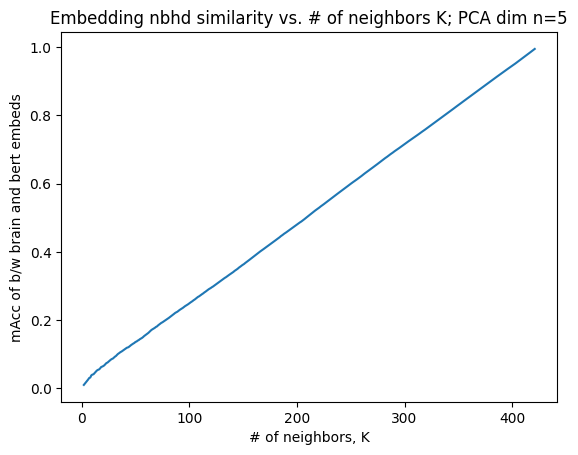

In [87]:
D = 5
K_vals, macc_K, mIoU_K = make_plot_varyingK(brain_response, bert_embeddings, D)
plt.plot(K_vals, macc_K)
plt.ylabel("mAcc of b/w brain and bert embeds")
plt.xlabel(f"# of neighbors, K")
plt.title("Embedding nbhd similarity vs. # of neighbors K; PCA dim n=5")
plt.show()

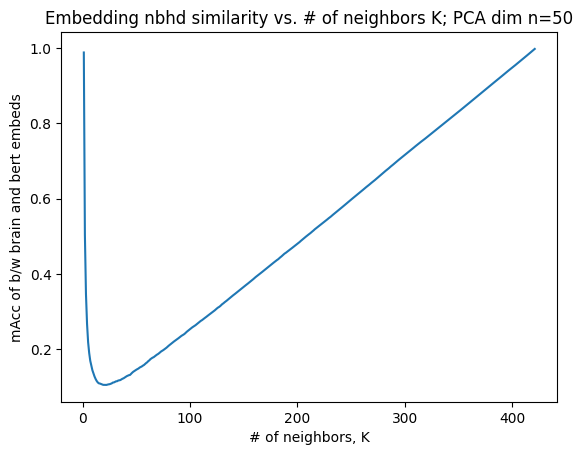

In [73]:
D = 50
K_vals, macc_K, mIoU_K = make_plot_varyingK(brain_response, bert_embeddings, D)
plt.plot(K_vals, macc_K)
plt.ylabel("mAcc of b/w brain and bert embeds")
plt.xlabel(f"# of neighbors, K")
plt.title(f"Embedding nbhd similarity vs. # of neighbors K; PCA dim n={D}")
plt.show()

100%|██████████| 421/421 [01:36<00:00,  4.34it/s]


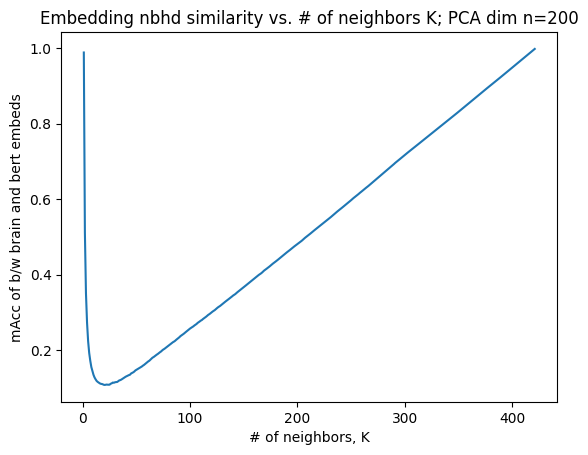

In [75]:
D = 200
K_vals, macc_K, mIoU_K = make_plot_varyingK(brain_response, bert_embeddings, D)
plt.plot(K_vals, macc_K)
plt.ylabel("mAcc of b/w brain and bert embeds")
plt.xlabel(f"# of neighbors, K")
plt.title(f"Embedding nbhd similarity vs. # of neighbors K; PCA dim n={D}")
plt.show()

## Vary N (PCA dim)

In [24]:
def make_plot_varyingN(brain_response, bert_embeddings, K=50):
    maxN = len(brain_response)
    N_vals = np.arange(2, maxN-2)
    mIoU_N = []
    macc_N = []

    bert_neighbors = get_knn_neighbors(bert_embeddings, K)
    for N in tqdm(N_vals):
        brain_vecs = get_pca_embeddings(brain_response, N)
        brain_nbrs = get_knn_neighbors(brain_vecs, K)
        mIoU, macc = get_mIoU(brain_nbrs, bert_neighbors)
        mIoU_N.append(mIoU)
        macc_N.append(macc)
    return N_vals, macc_N, mIoU_N

100%|██████████| 418/418 [13:09<00:00,  1.89s/it]


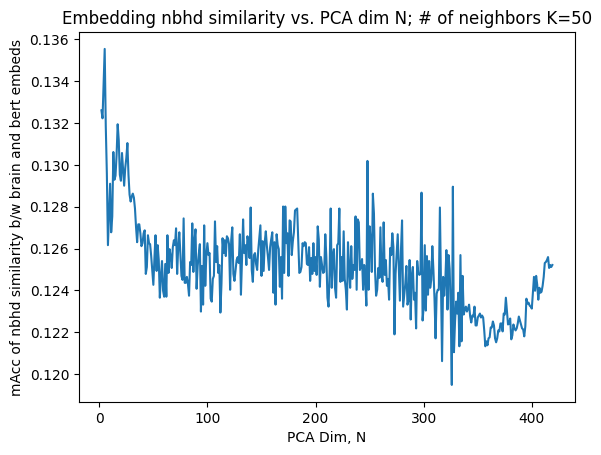

In [25]:
K = 50
N_vals, macc_N, mIoU_N = make_plot_varyingN(brain_response, bert_embeddings, K)
plt.plot(N_vals, macc_N)
plt.ylabel("mAcc of nbhd similarity b/w brain and bert embeds")
plt.xlabel(f"PCA Dim, N")
plt.title(f"Embedding nbhd similarity vs. PCA dim N; # of neighbors K={K}")
plt.show()

## Old code

In [14]:
def get_accuracy(brain_response, bert_embeddings, k, n):
    pca = PCA(n_components=n)
    brainPrincipalComponents = pca.fit_transform(brain_response)
    
    brain_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(brainPrincipalComponents)
    bert_nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(bert_embeddings)

    _, brain_indices = brain_nbrs.kneighbors(brainPrincipalComponents)
    _, bert_indices = bert_nbrs.kneighbors(bert_embeddings)
    
    accuracy = []

    for i in range(len(bert_indices)):
        brain_knn = brain_indices[i]
        bert_knn = bert_indices[i]
        correct = 0
        for nbr in brain_knn:
            if nbr in bert_knn:
                correct+=1
        accuracy.append(correct/k) 
    accuracy = np.array(accuracy)
    
    return accuracy.mean()

In [54]:
get_accuracy(brain_response, bert_embeddings, k, n)

0.2184834123222749

In [55]:
import matplotlib.pyplot as plt

k = 50 # default k
n = 5 # default n

k_list = np.arange(5, 300, 5)
n_list = np.arange(10, 400, 50)

In [56]:
accuracy_with_k = []
accuracy_with_n = []

In [57]:
for temp_k in k_list:
    accuracy = get_accuracy(brain_response, bert_embeddings, temp_k, n)
    accuracy_with_k.append(accuracy)

ValueError: x and y must have same first dimension, but have shapes (59,) and (0,)

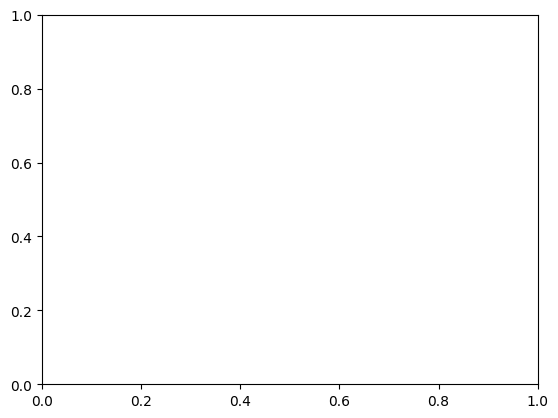

In [19]:
plt.plot(k_list, accuracy_with_k)
plt.ylabel("accuracy")
plt.xlabel(f"k")
plt.title("Embedding local neighborhood similarity varying the # of neighbors k, PCA dim n=5")
plt.show()

In [148]:
for temp_n in n_list:
    accuracy = get_accuracy(brain_response, bert_embeddings, k, temp_n)
    accuracy_with_n.append(accuracy)

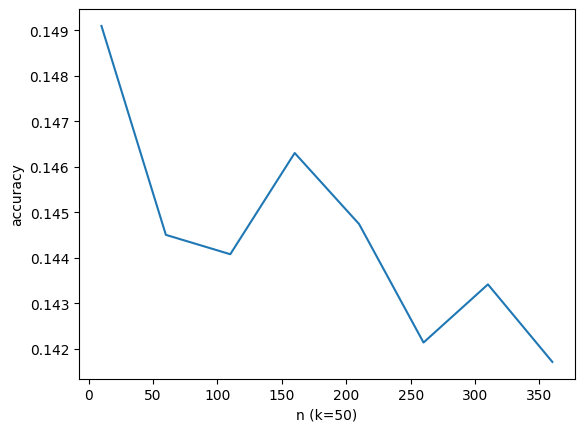

In [149]:
plt.plot(n_list, accuracy_with_n)
plt.ylabel("accuracy")
plt.xlabel(f"n (k={k})")
plt.show()